In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import string
from numpy.random import normal,random,seed
from scipy.stats import norm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('V3.csv')

In [4]:
df.head()

,DATE_ID,CAMPAIGN,KEYWORD,_POSITION,CLICKS,CPC,IMPRESSIONS,MEDIA_COST,CTR,Flag,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded
0,20170521,Non Brand | Condition | Geo,symptoms of asthma,2.08,3.0,1.8,51.0,5.4,0.058824,1.0,1,7,1,2.0,0,1,0,0,1
1,20170521,Brand,product1 spacer,1.00,0.0,0.0,2.0,0.0,0.000000,0.0,2,7,2,2.0,0,1,0,1,0
2,20170521,Non Brand | Treatment | National,how to prevent asthma,1.48,0.0,0.0,4.0,0.0,0.000000,0.0,3,7,3,2.0,0,1,0,0,1
3,20170521,Non Brand | Info | Geo,facts about asthma,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,4,7,4,2.0,1,0,0,0,1
4,20170521,Non Brand | Condition | Geo,asthma symptoms in children,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,1,7,5,2.0,1,0,0,0,1


In [4]:
#Perfrom log transformation because the CTR and Clicks are clustered to floor and ceiling

df['logCTR'] = np.log(df['CTR']+1)
df['logClicks'] = np.log(df['CLICKS']+1)
df['logImpression'] = np.log(df['IMPRESSIONS']+1)
df.head(5)

,DATE_ID,CAMPAIGN,KEYWORD,_POSITION,CLICKS,CPC,IMPRESSIONS,MEDIA_COST,CTR,Flag,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded,logCTR,logClicks,logImpression
0,20170521,Non Brand | Condition | Geo,symptoms of asthma,2.08,3.0,1.8,51.0,5.4,0.058824,1.0,1,7,1,2.0,0,1,0,0,1,0.057158,1.386294,3.951244
1,20170521,Brand,product1 spacer,1.00,0.0,0.0,2.0,0.0,0.000000,0.0,2,7,2,2.0,0,1,0,1,0,0.000000,0.000000,1.098612
2,20170521,Non Brand | Treatment | National,how to prevent asthma,1.48,0.0,0.0,4.0,0.0,0.000000,0.0,3,7,3,2.0,0,1,0,0,1,0.000000,0.000000,1.609438
3,20170521,Non Brand | Info | Geo,facts about asthma,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,4,7,4,2.0,1,0,0,0,1,0.000000,0.000000,0.000000
4,20170521,Non Brand | Condition | Geo,asthma symptoms in children,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,1,7,5,2.0,1,0,0,0,1,0.000000,0.000000,0.000000


In [5]:
np.isfinite(df.logCTR).all()

False

In [6]:
np.where(df.logCTR >= np.finfo(np.float64).max)

(array([ 81826, 245823], dtype=int64),)

In [7]:
df["logCTR"].iloc[81826] = 0
df["logCTR"].iloc[245823] = 0

C:\Users\zjx04\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
np.isfinite(df.logClicks).all()

True

In [26]:
np.isfinite(df.logImpression).all()

True

### Regression on log CTR

In [57]:
#Remove CPC and keep media_cost
X = df.drop(['DATE_ID','CAMPAIGN','KEYWORD','IMPRESSIONS','CTR','Flag','CLICKS','logCTR','logClicks','CPC','logImpression'],
            axis=1)
Y = df['logCTR'].values

In [9]:
X['CAMP_ID'].isnull().sum()

0

In [10]:
np.isfinite(Y).all(), np.isfinite(X).all()

(True,
 _POSITION                  True
 MEDIA_COST                 True
 CAMP_ID                    True
 week                       True
 KW_ID                      True
 Q                          True
 NETWORK_Bing               True
 NETWORK_Google             True
 NETWORK_Yahoo              True
 CAMPAIGN_TYPE_Branded      True
 CAMPAIGN_TYPE_Unbranded    True
 dtype: bool)

In [11]:
np.any(np.isnan(X)), np.any(np.isnan(Y))

(False, False)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=121)

In [13]:
x_train.head()

,_POSITION,MEDIA_COST,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded
121809,8.00,0.00,9,7,70,1.0,1,0,0,0,1
377912,1.89,21.78,9,4,110,2.0,0,1,0,0,1
281204,4.72,0.00,6,5,330,3.0,1,0,0,0,1
64222,4.00,0.00,5,4,1254,1.0,1,0,0,0,1
45062,4.67,0.00,1,5,658,2.0,0,1,0,0,1


#### Base RF model

In [13]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=121)
rf.fit(x_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)

In [30]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5

In [15]:
# Evaluate the test set RMSE
rmse_test = RMSE(y_test, y_pred)
rmse_train = RMSE(y_train, y_pred_train)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.10
Train set RMSE of rf: 0.10


In [16]:
r2_train = np.corrcoef(y_train, y_pred_train)**2
r2_test = np.corrcoef(y_test, y_pred)**2

In [17]:
r2_train, r2_test

(array([[1.        , 0.45606091],
        [0.45606091, 1.        ]]),
 array([[1.        , 0.45646849],
        [0.45646849, 1.        ]]))

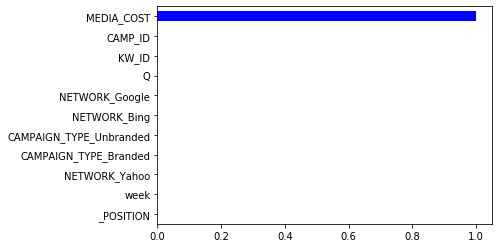

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

In [19]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=0.12, n_estimators=400, random_state=121)>

#### Randomize Search RF

In [20]:
param_grid = {'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [0.08, 0.10, 0.12],
              'n_estimators': [300,400,500]}

In [22]:
rf0 = RandomForestRegressor(random_state=12, oob_score = True, max_features=6)

In [23]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf0, param_distributions = param_grid, scoring = "r2",
                               n_iter = 10, cv = 3, verbose = 1, n_jobs = -1)

In [25]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.2min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_features=6,
                                                   oob_score=True,
                                                   random_state=12),
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0.08, 0.1, 0.12],
                                        'n_estimators': [300, 400, 500]},
                   scoring='r2', verbose=1)

In [26]:
print('train RMSE =', RMSE(y_test, rf_random.best_estimator_.predict(x_test)))

train RMSE = 0.09768743095114177


In [27]:
rf_random.best_params_

{'n_estimators': 400, 'min_samples_leaf': 0.1, 'max_features': 'auto'}

In [28]:
print("r2_train", np.corrcoef(y_train, rf_random.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, rf_random.best_estimator_.predict(x_test))**2)

r2_train [[1.         0.45606091]
 [0.45606091 1.        ]]
r2_test [[1.         0.45646849]
 [0.45646849 1.        ]]


#### Base XGboost model

In [29]:
param = {'objective': 'reg:squarederror'}

In [30]:
dtrain = xgb.DMatrix(x_train, label=y_train)

In [31]:
cvSearch = xgb.cv(param, dtrain, nfold = 3, num_boost_round = 50, verbose_eval = 10)
cvSearch.tail(10)

[0]	train-rmse:0.33666+0.00005	test-rmse:0.33666+0.00014
[10]	train-rmse:0.06682+0.00011	test-rmse:0.06768+0.00036
[20]	train-rmse:0.06394+0.00021	test-rmse:0.06551+0.00029
[30]	train-rmse:0.06196+0.00007	test-rmse:0.06431+0.00039
[40]	train-rmse:0.06069+0.00013	test-rmse:0.06370+0.00033
[49]	train-rmse:0.05968+0.00007	test-rmse:0.06329+0.00044


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
40,0.060691,0.000128,0.063697,0.000327
41,0.060554,0.000076,0.063644,0.000385
42,0.060454,0.000060,0.063615,0.000387
43,0.060334,0.000058,0.063586,0.000417
44,0.060262,0.000052,0.063550,0.000398
45,0.060140,0.000009,0.063508,0.000372
46,0.059946,0.000095,0.063369,0.000403
47,0.059874,0.000065,0.063364,0.000409
48,0.059732,0.000083,0.063293,0.000441
49,0.059682,0.000070,0.063292,0.000445


best number of rounds = 48
rmse = 0.06329266666666666


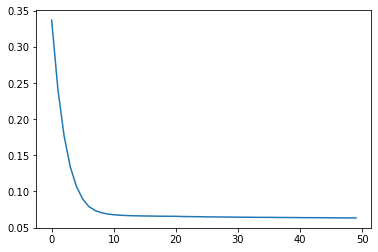

In [32]:
eps = 1e-6
bestNR = np.argmax(cvSearch['test-rmse-mean']<eps+min(cvSearch['test-rmse-mean']))
bestRMSE = cvSearch.loc[bestNR,'test-rmse-mean']
plt.plot(cvSearch['test-rmse-mean'])
print('best number of rounds =',bestNR)
print('rmse =',bestRMSE) 
#using bestNR

In [33]:
modelSearch = xgb.train(param, dtrain, num_boost_round = bestNR)
print(RMSE(y_test, modelSearch.predict(xgb.DMatrix(x_test))))

0.06271435742223949


In [34]:
regSearch = XGBRegressor(objective='reg:squarederror', n_estimators=bestNR)
regSearch.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=48, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
print(RMSE(y_test, regSearch.predict(x_test)))

0.06271435742223949


In [36]:
print("r2_train", np.corrcoef(y_train, regSearch.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, regSearch.predict(x_test))**2)

r2_train [[1.         0.79361676]
 [0.79361676 1.        ]]
r2_test [[1.         0.77661132]
 [0.77661132 1.        ]]


In [37]:
regSearch1 = XGBRegressor(objective='reg:squarederror', n_estimators=bestNR, max_depth=6, learning_rate=0.5)
regSearch1.fit(x_train, y_train)
print(RMSE(y_test, regSearch1.predict(x_test)))

0.06164485815582831


In [38]:
print("r2_train", np.corrcoef(y_train, regSearch1.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, regSearch1.predict(x_test))**2)

r2_train [[1.         0.80725787]
 [0.80725787 1.        ]]
r2_test [[1.         0.78375905]
 [0.78375905 1.        ]]


#### Randomize Search XGboost

In [59]:
param_grid = {
    'learning_rate': [0.3, 0.5, 0.7],
    'max_depth': [4,5,6],
    'n_estimators': [50, 75, 100]
}

In [60]:
grid = RandomizedSearchCV(estimator = XGBRegressor(objective= 'reg:squarederror', seed=122), scoring = 'r2',
                          param_distributions = param_grid, n_jobs=-1, cv=3)

grid.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [61]:
grid.best_params_

{'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3}

In [62]:
print(RMSE(y_test, grid.best_estimator_.predict(x_test)))

0.06107584786165932


In [63]:
print("r2_train", np.corrcoef(y_train, grid.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, grid.best_estimator_.predict(x_test))**2)

r2_train [[1.         0.81868729]
 [0.81868729 1.        ]]
r2_test [[1.         0.78788367]
 [0.78788367 1.        ]]


#### k-fold cv search XGboost

In [14]:
# k-fold cross validation evaluation of xgboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = xgb.XGBRegressor()
kfold = KFold(n_splits=10, random_state=27)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

C:\Users\zjx04\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 77.24% (2.25%)


In [18]:
# best parameters dict
params = {'colsample_bytree': 1.0, 
          'eta': 0.01,
          'eval_metric': 'rmse',
          'max_depth': 10,
          'min_child_weight': 5,
          'objective': 'reg:squarederror',
          'subsample': 1.0}

In [16]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [19]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.47025
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.46564
[2]	Test-rmse:0.46101
[3]	Test-rmse:0.45643
[4]	Test-rmse:0.45202
[5]	Test-rmse:0.44766
[6]	Test-rmse:0.44329
[7]	Test-rmse:0.43891
[8]	Test-rmse:0.43458
[9]	Test-rmse:0.43043
[10]	Test-rmse:0.42608
[11]	Test-rmse:0.42197
[12]	Test-rmse:0.41786
[13]	Test-rmse:0.41374
[14]	Test-rmse:0.40977
[15]	Test-rmse:0.40571
[16]	Test-rmse:0.40187
[17]	Test-rmse:0.39795
[18]	Test-rmse:0.39397
[19]	Test-rmse:0.39026
[20]	Test-rmse:0.38641
[21]	Test-rmse:0.38264
[22]	Test-rmse:0.37889
[23]	Test-rmse:0.37523
[24]	Test-rmse:0.37169
[25]	Test-rmse:0.36803
[26]	Test-rmse:0.36447
[27]	Test-rmse:0.36094
[28]	Test-rmse:0.35748
[29]	Test-rmse:0.35395
[30]	Test-rmse:0.35056
[31]	Test-rmse:0.34714
[32]	Test-rmse:0.34391
[33]	Test-rmse:0.34053
[34]	Test-rmse:0.33726
[35]	Test-rmse:0.33404
[36]	Test-rmse:0.33083
[37]	Test-rmse:0.32758
[38]	Test-rmse:0.32451
[39]	Test-rmse:0.32132
[40]	Test-rmse:0.31823
[41]	Test-

[344]	Test-rmse:0.06302
[345]	Test-rmse:0.06297
[346]	Test-rmse:0.06293
[347]	Test-rmse:0.06288
[348]	Test-rmse:0.06284
[349]	Test-rmse:0.06280
[350]	Test-rmse:0.06276
[351]	Test-rmse:0.06274
[352]	Test-rmse:0.06269
[353]	Test-rmse:0.06266
[354]	Test-rmse:0.06261
[355]	Test-rmse:0.06259
[356]	Test-rmse:0.06254
[357]	Test-rmse:0.06251
[358]	Test-rmse:0.06246
[359]	Test-rmse:0.06245
[360]	Test-rmse:0.06241
[361]	Test-rmse:0.06237
[362]	Test-rmse:0.06233
[363]	Test-rmse:0.06232
[364]	Test-rmse:0.06227
[365]	Test-rmse:0.06224
[366]	Test-rmse:0.06222
[367]	Test-rmse:0.06218
[368]	Test-rmse:0.06217
[369]	Test-rmse:0.06213
[370]	Test-rmse:0.06210
[371]	Test-rmse:0.06208
[372]	Test-rmse:0.06203
[373]	Test-rmse:0.06202
[374]	Test-rmse:0.06198
[375]	Test-rmse:0.06196
[376]	Test-rmse:0.06193
[377]	Test-rmse:0.06189
[378]	Test-rmse:0.06187
[379]	Test-rmse:0.06186
[380]	Test-rmse:0.06182
[381]	Test-rmse:0.06180
[382]	Test-rmse:0.06178
[383]	Test-rmse:0.06176
[384]	Test-rmse:0.06172
[385]	Test-rmse:

In [20]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 0.06 in 500 rounds


In [22]:
print("r2_train", np.corrcoef(y_train, model.predict(dtrain))**2)
print("r2_test", np.corrcoef(y_test, model.predict(dtest))**2)

r2_train [[1.         0.83384603]
 [0.83384603 1.        ]]
r2_test [[1.         0.79266028]
 [0.79266028 1.        ]]


In [23]:
model.save_model("xgboost.model")

#### Adaboost

In [44]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [45]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=2, random_state=1)
# Instantiate ada
ada = AdaBoostRegressor(base_estimator=dt, n_estimators=180, random_state=1)

In [46]:
ada.fit(x_train, y_train)

# Compute the probabilities of obtaining the positive class
ada_y_pred = ada.predict(x_test)

In [47]:
ada_y_pred_train = ada.predict(x_train)
# Evaluate the test set RMSE
ada_rmse_test = RMSE(y_test, ada_y_pred)**(1/2)
ada_rmse_train = RMSE(y_train, ada_y_pred_train)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))

Test set RMSE of rf: 0.30
Train set RMSE of rf: 0.30


In [48]:
print("r2_train", np.corrcoef(y_train, ada_y_pred_train)**2)
print("r2_test", np.corrcoef(y_test, ada_y_pred)**2)

r2_train [[1.        0.5699613]
 [0.5699613 1.       ]]
r2_test [[1.         0.56972855]
 [0.56972855 1.        ]]


### Regression on log Clicks

In [27]:
X1 = df.drop(['DATE_ID','CAMPAIGN','KEYWORD','IMPRESSIONS','CTR','Flag','CLICKS','logCTR','logClicks','CPC',
              'logImpression'], axis=1)
Y1 = df['logClicks'].values

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size = 0.3, random_state=121)

#### Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=121)
rf.fit(x_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)

In [31]:
# Evaluate the test set RMSE
rmse_test = RMSE(y_test, y_pred)
rmse_train = RMSE(y_train, y_pred_train)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.30
Train set RMSE of rf: 0.30


In [33]:
r2_train = np.corrcoef(y_train, y_pred_train)**2
r2_test = np.corrcoef(y_test, y_pred)**2
print(r2_train)
print(r2_test)

[[1.         0.67322421]
 [0.67322421 1.        ]]
[[1.         0.67262969]
 [0.67262969 1.        ]]


In [34]:
param_grid = {'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [0.08, 0.10, 0.12],
              'n_estimators': [300,400,500]}

In [35]:
rf0 = RandomForestRegressor(random_state=12, oob_score = True, max_features=6)

In [36]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf0, param_distributions = param_grid, scoring = "r2",
                               n_iter = 20, cv = 3, verbose = 1, n_jobs = -1)

In [37]:
rf_random.fit(x_train, y_train)

C:\Users\zjx04\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 23.3min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_features=6,
                                                   oob_score=True,
                                                   random_state=12),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0.08, 0.1, 0.12],
                                        'n_estimators': [300, 400, 500]},
                   scoring='r2', verbose=1)

In [40]:
rf_random.best_params_

{'n_estimators': 500, 'min_samples_leaf': 0.1, 'max_features': 'auto'}

In [38]:
print('train RMSE =', RMSE(y_test, rf_random.best_estimator_.predict(x_test)))

train RMSE = 0.30039708878409865


In [39]:
print("r2_train", np.corrcoef(y_train, rf_random.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, rf_random.best_estimator_.predict(x_test))**2)

r2_train [[1.         0.67322421]
 [0.67322421 1.        ]]
r2_test [[1.        0.6726297]
 [0.6726297 1.       ]]


#### XGboost

In [42]:
param_grid = {
    'learning_rate': [0.3, 0.5, 0.7],
    'max_depth': [4,5,6],
    'n_estimators': [50, 75, 100]
}

In [43]:
grid = RandomizedSearchCV(estimator = XGBRegressor(objective= 'reg:squarederror', seed=122), scoring = 'r2',
                          param_distributions = param_grid, n_jobs=-1, cv=3)

grid.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [44]:
grid.best_params_

{'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3}

In [45]:
print(RMSE(y_test, grid.best_estimator_.predict(x_test)))

0.08966339732352833


In [46]:
print("r2_train", np.corrcoef(y_train, grid.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, grid.best_estimator_.predict(x_test))**2)

r2_train [[1.        0.9756333]
 [0.9756333 1.       ]]
r2_test [[1.         0.97083273]
 [0.97083273 1.        ]]


### Regression on log Impressions

In [47]:
X2 = df.drop(['DATE_ID','CAMPAIGN','KEYWORD','IMPRESSIONS','CTR','Flag','CLICKS','logCTR','logClicks','CPC',
              'logImpression'], axis=1)
Y2 = df['logImpression'].values

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X2, Y2, test_size = 0.3, random_state=121)

#### Random Forest

In [49]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=121)
rf.fit(x_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)

In [50]:
# Evaluate the test set RMSE
rmse_test = RMSE(y_test, y_pred)
rmse_train = RMSE(y_train, y_pred_train)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.95
Train set RMSE of rf: 0.95


In [51]:
r2_train = np.corrcoef(y_train, y_pred_train)**2
r2_test = np.corrcoef(y_test, y_pred)**2
print(r2_train)
print(r2_test)

[[1.         0.29862877]
 [0.29862877 1.        ]]
[[1.         0.30038717]
 [0.30038717 1.        ]]


#### XGboost

In [52]:
param_grid = {
    'learning_rate': [0.3, 0.5, 0.7],
    'max_depth': [4,5,6],
    'n_estimators': [50, 75, 100]
}

In [53]:
grid = RandomizedSearchCV(estimator = XGBRegressor(objective= 'reg:squarederror', seed=122), scoring = 'r2',
                          param_distributions = param_grid, n_jobs=-1, cv=3)

grid.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [54]:
grid.best_params_

{'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.7}

In [55]:
print(RMSE(y_test, grid.best_estimator_.predict(x_test)))

0.4776308761249928


In [56]:
print("r2_train", np.corrcoef(y_train, grid.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, grid.best_estimator_.predict(x_test))**2)

r2_train [[1.         0.83764718]
 [0.83764718 1.        ]]
r2_test [[1.       0.822021]
 [0.822021 1.      ]]
